# Import Libraries

In [1]:
# Import all libraries 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import re
import datetime as dt
from datetime import timedelta
from dateutil import parser
import os
import pydot
from sklearn import model_selection, preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding
from tensorflow.keras.utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import random

/Users/Amey/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/Amey/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Amey/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Amey/anaconda3/lib/python3.6/site-packages/tensorboard/

In [35]:
master_df = pd.read_csv('../data/master_data_SATM.csv')

In [28]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2246 entries, 0 to 2245
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       2246 non-null   float64
 1   text                     2246 non-null   object 
 2   favorites                2246 non-null   int64  
 3   retweets                 2246 non-null   int64  
 4   date                     2246 non-null   object 
 5   tweet_datetime           2246 non-null   object 
 6   date_part                2246 non-null   object 
 7   time_part                2246 non-null   object 
 8   hour                     2246 non-null   int64  
 9   year                     2246 non-null   int64  
 10  month                    2246 non-null   int64  
 11  text_topic_modelling     2197 non-null   object 
 12  text_EDA                 2246 non-null   object 
 13  text_sentiment_analysis  2212 non-null   object 
 14  text_LSTM               

In [4]:
master_df.head()

,id,text,favorites,retweets,date,tweet_datetime,date_part,time_part,hour,year,...,60mins_price_diff_abs,60mins_price_diff_perc,45mins_price_diff_abs,45mins_price_diff_perc,30mins_price_diff_abs,30mins_price_diff_perc,15mins_price_diff_abs,15mins_price_diff_perc,compound,topic
0,9.353400e+17,Thank you Rand! https://t.co/NvPeleVmub,42793,9125,2017-11-28 02:50:00,2017-11-28 10:50:00,2017-11-28,10:50:00,10,2017,...,0.385000,0.001475,0.115000,0.000440,-0.010000,-0.000038,0.050000,0.000191,0.4199,1
1,8.997980e+17,"Join me live from Fort Myer in Arlington, Virg...",36009,4891,2017-08-22 01:00:00,2017-08-22 09:00:00,2017-08-22,09:00:00,9,2017,...,0.590000,0.002421,0.590000,0.002421,-0.090000,-0.000369,-0.040000,-0.000164,0.2960,1
2,8.939700e+17,Thank you Nicole! https://t.co/KlWN05uFOx,43367,8275,2017-05-08 23:01:00,2017-05-09 07:01:00,2017-05-09,07:01:00,7,2017,...,0.065000,0.000271,0.015000,0.000063,0.085000,0.000354,0.065000,0.000271,0.4199,1
3,8.819770e+17,Thank you to Shawn Steel for the nice words on...,50956,7465,2017-03-07 20:44:00,2017-03-08 04:44:00,2017-03-08,04:44:00,4,2017,...,0.142857,0.000603,0.096000,0.000405,0.130000,0.000549,0.035000,0.000148,0.6486,2
4,8.787250e+17,MAKE AMERICA GREAT AGAIN!,134210,36346,2017-06-24 21:23:00,2017-06-25 05:23:00,2017-06-25,05:23:00,5,2017,...,0.005714,0.000023,0.004286,0.000018,0.002857,0.000012,0.001429,0.000006,0.6588,6


# 1. Regression

## Linear Regression

In [5]:
dummy_topics = pd.get_dummies(master_df['topic'])

X_lr = pd.concat([master_df.loc[:, ['compound', 'favorites', 'retweets']], dummy_topics], axis=1)
y_lr = master_df.loc[:, '60mins_price_diff_abs']

In [6]:
# Removing correlated features

correlated_features = set()
correlation_matrix = X_lr.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
X_lr.drop(labels=correlated_features, axis=1, inplace=True)

In [7]:
# Train test split and resampling

X_train_lr, X_test_lr, y_train_lr, y_test_lr = model_selection.train_test_split(X_lr, y_lr, test_size = 0.33, random_state = 2020)


In [8]:
# Normalize all values
X_train_lr = preprocessing.scale(X_train_lr)
y_train_lr = preprocessing.scale(y_train_lr)
X_test_lr = preprocessing.scale(X_test_lr)
y_test_lr = preprocessing.scale(y_test_lr)

# Linear regression
regr = LinearRegression()
regr.fit(X_train_lr, y_train_lr)

y_pred_lr = regr.predict(X_test_lr)
print('Linear metrics for stock price 60 mins after tweet')
print('Linear score:', regr.score(X_test_lr, y_test_lr))
print('Linear MSE', metrics.mean_squared_error(y_test_lr, y_pred_lr))
print(regr.coef_, '\n')

print('-'*64)

num_C = 5
C = [1.0] * num_C
for i in range(num_C):
    C[i] = pow(10, i-5)
print('Ridge and Lasso metrics for stock price 60 mins after tweet')
for i in range(5):
    # Lasso Regression
    lasso = Lasso(alpha = C[i])
    lasso.fit(X_train_lr, y_train_lr)
    y_pred = regr.predict(X_test_lr)
    print('Alpha = ', C[i])
    print('Lasso score:', lasso.score(X_test_lr, y_test_lr))
    print('Lasso MSE', metrics.mean_squared_error(y_test_lr, y_pred_lr))
    print('Lasso coefs:', lasso.coef_, '\n')
    
    # Ridge regression
    ridge = Ridge(alpha = C[i])
    ridge.fit(X_train_lr, y_train_lr)
    y_pred_lr = regr.predict(X_test_lr)
    print('Ridge score:', ridge.score(X_test_lr, y_test_lr))
    print('Ridge MSE', metrics.mean_squared_error(y_test_lr, y_pred_lr))
    print('Ridge coefs:', ridge.coef_, '\n')
    print('-'*64)

Linear metrics for stock price 60 mins after tweet
Linear score: -0.007795931488358665
Linear MSE 1.0077959314883587
[ 0.0181782   0.0243723   0.02401412  0.02799019 -0.00244868 -0.00612251
 -0.00676062 -0.01897089 -0.04155745  0.01654451 -0.01743998  0.02764934] 

----------------------------------------------------------------
Ridge and Lasso metrics for stock price 60 mins after tweet
Alpha =  1e-05
Lasso score: -0.007831769235890018
Lasso MSE 1.0077959314883587
Lasso coefs: [ 0.01816063  0.02436169  0.0315953   0.03359443  0.00195138 -0.
 -0.00037844 -0.01408171 -0.0355264   0.02310347 -0.01194847  0.030592  ] 

Ridge score: -0.007795931412734269
Ridge MSE 1.0077959314883587
Ridge coefs: [ 0.0181782   0.0243723   0.02401412  0.02799019 -0.00244868 -0.00612251
 -0.00676062 -0.01897089 -0.04155745  0.01654451 -0.01743998  0.02764934] 

----------------------------------------------------------------
Alpha =  0.0001
Lasso score: -0.007780232425700584
Lasso MSE 1.0077959314883587
Lasso

# LSTM Regression

## Model A: Word Vectors as Input

### Method 1: Using Word2Vec word embedding

In [384]:
lstm_reg_a_df = master_df.dropna(subset=['text_LSTM'])

X_lstm_reg_a = lstm_reg_a_df.loc[:, 'text_LSTM']
y_lstm_reg_a = lstm_reg_a_df.loc[:, '60mins_price_diff_abs']

In [385]:
X_train_lstm_reg_a, X_test_lstm_reg_a, y_train_lstm_reg_a, y_test_lstm_reg_a = train_test_split(X_lstm_reg_a, y_lstm_reg_a, test_size=0.33, random_state=2020)

In [386]:
# Add words into corpus list
lstm_reg_a_w2v_corpus_list = []

for i in X_train_lstm_reg_a:
    lstm_reg_a_w2v_corpus_list.append(i.split())
    
# Train Word2Vec
lstm_reg_a_w2v_model = Word2Vec(lstm_reg_a_w2v_corpus_list, min_count=1, size=100)
lstm_reg_a_w2v_weights = lstm_reg_a_w2v_model.wv.vectors

# Find length of longest sentence (for padding later on)
lstm_reg_a_w2v_num_words = [len(i) for i in lstm_reg_a_w2v_corpus_list]
lstm_reg_a_w2v_longest_sentence_len = max(lstm_reg_a_w2v_num_words)

# Pad sentences that are shorter than length of longest sentence in training data
def word2vec_sentence_to_indices_padded(sentences, longest_sentence_len, word2vec_model):
    result = []
    for sentence in sentences:
        indices = []
        sentence_splitted = str(sentence).split()
        for word in sentence_splitted:
            if word in word2vec_model.wv.vocab:
                indices.append(word2vec_model.wv.vocab[word].index)
        result.append(indices)
    return keras.preprocessing.sequence.pad_sequences(result, maxlen=longest_sentence_len, padding='pre')

X_train_lstm_reg_a_w2v_padded = word2vec_sentence_to_indices_padded(X_train_lstm_reg_a, lstm_reg_a_w2v_longest_sentence_len, lstm_reg_a_w2v_model)
X_test_lstm_reg_a_w2v_padded = word2vec_sentence_to_indices_padded(X_test_lstm_reg_a, lstm_reg_a_w2v_longest_sentence_len, lstm_reg_a_w2v_model)

In [387]:
def create_lstm_reg_a_w2v(pretrained_weights, longest_sentence_len):
    vocab_size, embedding_size = pretrained_weights.shape
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=longest_sentence_len, dtype='int32'))
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_size, weights=[pretrained_weights], trainable=False))  
    model.add(layers.LSTM(4, return_sequences=True, name='LSTM1'))
    model.add(layers.Dropout(0.2,name='Dropout1'))
    model.add(layers.LSTM(4, return_sequences=False, name='LSTM2'))
    model.add(layers.Dropout(0.2,name='Dropout2'))
    model.add(layers.Dense(4,name='Dense',activation='tanh'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1,activation='linear'))
    return model

In [388]:
lstm_reg_a_w2v_ann = create_lstm_reg_a_w2v(lstm_reg_a_w2v_weights, lstm_reg_a_w2v_longest_sentence_len)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
lstm_reg_a_w2v_ann.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae'])
lstm_reg_a_w2v_ann.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 100, 100)          433600    
_________________________________________________________________
LSTM1 (LSTM)                 (None, 100, 4)            1680      
_________________________________________________________________
Dropout1 (Dropout)           (None, 100, 4)            0         
_________________________________________________________________
LSTM2 (LSTM)                 (None, 4)                 144       
_________________________________________________________________
Dropout2 (Dropout)           (None, 4)                 0         
_________________________________________________________________
Dense (Dense)                (None, 4)                 20        
_________________________________________________________________
dropout_29 (Dropout)         (None, 4)               

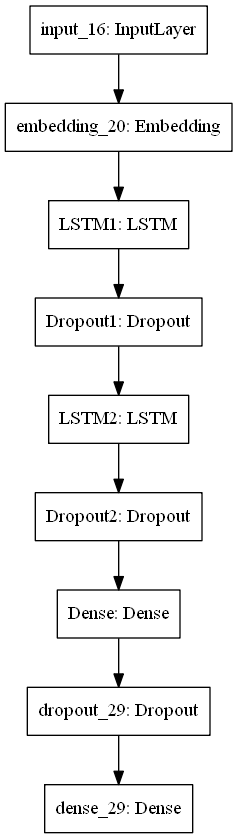

In [389]:
plot_model(
    lstm_reg_a_w2v_ann,
    to_file="../data/lstm_reg_a_w2v_ann.png",
    show_shapes=False,
    show_layer_names=True,
    rankdir="TB"
)

In [390]:
now = dt.datetime.now()
dt_string = now.strftime("%d%m%Y %H%Mh")

lstm_reg_a_w2v_checkpoint_filepath = f'../models/lstm_reg_a_w2v/lstm_reg_a_w2v_{dt_string}.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=lstm_reg_a_w2v_checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose = 1,
    save_best_only=True) 

lstm_reg_a_w2v_history = lstm_reg_a_w2v_ann.fit(X_train_lstm_reg_a_w2v_padded, y_train_lstm_reg_a, validation_split=0.33, epochs=30, callbacks=[model_checkpoint_callback])

Train on 987 samples, validate on 487 samples
Epoch 1/30
960/987 [============================>.] - ETA: 0s - loss: 0.2051 - mae: 0.2362
Epoch 00001: val_loss improved from inf to 0.19052, saving model to ./lstm_reg_a_w2v/lstm_reg_a_w2v_20112020 1607h.h5
987/987 [==============================] - 6s 6ms/sample - loss: 0.2023 - mae: 0.2347 - val_loss: 0.1905 - val_mae: 0.2159
Epoch 2/30
960/987 [============================>.] - ETA: 0s - loss: 0.2041 - mae: 0.2210
Epoch 00002: val_loss improved from 0.19052 to 0.19011, saving model to ./lstm_reg_a_w2v/lstm_reg_a_w2v_20112020 1607h.h5
987/987 [==============================] - 2s 2ms/sample - loss: 0.2019 - mae: 0.2208 - val_loss: 0.1901 - val_mae: 0.2130
Epoch 3/30
960/987 [============================>.] - ETA: 0s - loss: 0.2035 - mae: 0.2206
Epoch 00003: val_loss did not improve from 0.19011
987/987 [==============================] - 2s 2ms/sample - loss: 0.2002 - mae: 0.2197 - val_loss: 0.1902 - val_mae: 0.2134
Epoch 4/30
960/987 [=

In [391]:
lstm_reg_a_w2v_ann_loaded = create_lstm_reg_a_w2v(lstm_reg_a_w2v_weights, lstm_reg_a_w2v_longest_sentence_len)
lstm_reg_a_w2v_ann_loaded.load_weights(lstm_reg_a_w2v_checkpoint_filepath)
lstm_reg_a_w2v_ann_loaded.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae'])

In [392]:
dev_loss, dev_acc = lstm_reg_a_w2v_ann_loaded.evaluate(X_test_lstm_reg_a_w2v_padded, y_test_lstm_reg_a, verbose=1)

print(f"Training MSE: {np.sqrt(metrics.mean_squared_error(y_train_lstm_reg_a, lstm_reg_a_w2v_ann_loaded.predict(X_train_lstm_reg_a_w2v_padded)))}")
print(f"Test MSE: {np.sqrt(metrics.mean_squared_error(y_test_lstm_reg_a, lstm_reg_a_w2v_ann_loaded.predict(X_test_lstm_reg_a_w2v_padded)))}")
print(f"Test R^2: {metrics.r2_score(y_test_lstm_reg_a, lstm_reg_a_w2v_ann_loaded.predict(X_test_lstm_reg_a_w2v_padded))}")
print(f"Baseline MSE: {np.sqrt(metrics.mean_squared_error(y_test_lstm_reg_a, 0*y_test_lstm_reg_a))}")

726/726 [==============================] - 1s 2ms/sample - loss: 0.1670 - mae: 0.1997
Training MSE: 0.4434414538160375
Test MSE: 0.40869573540877296
Test R^2: -0.0004509446581950627
Baseline MSE: 0.4089276246535823


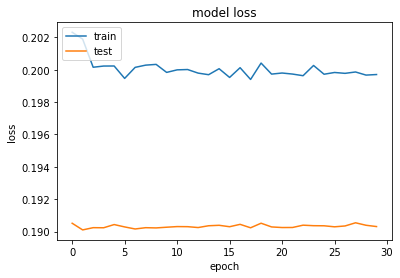

In [393]:
# summarize history for loss
plt.plot(lstm_reg_a_w2v_history.history['loss'])
plt.plot(lstm_reg_a_w2v_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Method 2: Using GloVe word embedding

In [394]:
# Import glove file 
dimension = 100
embeddings_index = {}
f = open(f'../data/glove/glove.twitter.27B.{dimension}d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train_lstm_reg_a)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1

#text to integers
sequences = tokenizer.texts_to_sequences(X_train_lstm_reg_a)
lstm_reg_a_glove_longest_sentence_len = 30
X_train_lstm_reg_a_glove_padded = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=lstm_reg_a_glove_longest_sentence_len, padding='pre')

print('Found %s unique tokens.' % len(word_index))

unique_words = set(word_index.keys())
def prepare_test_x_glove(x):
    global unique_words
    global word_index
    global lstm_reg_a_glove_longest_sentence_len
    
    result = []
    for tweet in x:
        indices = []
        for word in tweet.split():
            if word in unique_words:
                indices.append(word_index[word])
            else:
                indices.append(0)
            
        result.append(indices)
    return keras.preprocessing.sequence.pad_sequences(result, maxlen=lstm_reg_a_glove_longest_sentence_len, padding='pre')

X_test_lstm_reg_a_glove_padded = prepare_test_x_glove(X_test_lstm_reg_a)

Found 1193514 word vectors.
Found 4336 unique tokens.


In [395]:
embedding_matrix = np.zeros((vocab_size, dimension))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer_glove = Embedding(vocab_size,
                            100,
                            weights=[embedding_matrix],
                            input_length=lstm_reg_a_glove_longest_sentence_len,
                            trainable=False)

In [396]:
def create_lstm_reg_a_glove(longest_sentence_len):
    global embedding_layer_glove
    model = keras.Sequential()
    model.add(layers.Input(shape=longest_sentence_len, dtype='int32'))
    model.add(embedding_layer_glove)
    model.add(layers.LSTM(4, return_sequences=True, name='LSTM1'))
    model.add(layers.Dropout(0.2,name='Dropout1'))
    model.add(layers.LSTM(4, return_sequences=False, name='LSTM2'))
    model.add(layers.Dropout(0.2,name='Dropout2'))
    model.add(layers.Dense(4,name='Dense',activation='tanh'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1,activation='linear'))
    return model

In [397]:
lstm_reg_a_glove_ann = create_lstm_reg_a_glove(lstm_reg_a_glove_longest_sentence_len)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
lstm_reg_a_glove_ann.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae'])
lstm_reg_a_glove_ann.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 30, 100)           433700    
_________________________________________________________________
LSTM1 (LSTM)                 (None, 30, 4)             1680      
_________________________________________________________________
Dropout1 (Dropout)           (None, 30, 4)             0         
_________________________________________________________________
LSTM2 (LSTM)                 (None, 4)                 144       
_________________________________________________________________
Dropout2 (Dropout)           (None, 4)                 0         
_________________________________________________________________
Dense (Dense)                (None, 4)                 20        
_________________________________________________________________
dropout_31 (Dropout)         (None, 4)               

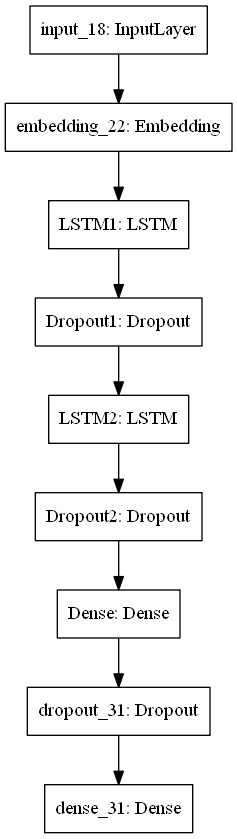

In [398]:
plot_model(
    lstm_reg_a_glove_ann,
    to_file="../data/lstm_reg_a_glove_ann.png",
    show_shapes=False,
    show_layer_names=True,
    rankdir="TB"
)

In [399]:
now = dt.datetime.now()
dt_string = now.strftime("%d%m%Y %H%Mh")

lstm_reg_a_glove_checkpoint_filepath = f'../models/lstm_reg_a_glove/lstm_reg_a_glove_{dt_string}.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=lstm_reg_a_glove_checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose = 1,
    save_best_only=True) 

lstm_reg_a_glove_history = lstm_reg_a_glove_ann.fit(X_train_lstm_reg_a_glove_padded, y_train_lstm_reg_a, validation_split=0.33, epochs=30, callbacks=[model_checkpoint_callback])

Train on 987 samples, validate on 487 samples
Epoch 1/30
896/987 [==========================>...] - ETA: 0s - loss: 0.2276 - mae: 0.2922
Epoch 00001: val_loss improved from inf to 0.19101, saving model to ./lstm_reg_a_glove/lstm_reg_a_glove_20112020 1611h.h5
987/987 [==============================] - 5s 5ms/sample - loss: 0.2336 - mae: 0.2909 - val_loss: 0.1910 - val_mae: 0.2243
Epoch 2/30
896/987 [==========================>...] - ETA: 0s - loss: 0.1995 - mae: 0.2372- ETA: 0s - loss: 0.2347 - mae: 0
Epoch 00002: val_loss improved from 0.19101 to 0.18979, saving model to ./lstm_reg_a_glove/lstm_reg_a_glove_20112020 1611h.h5
987/987 [==============================] - 1s 714us/sample - loss: 0.2043 - mae: 0.2386 - val_loss: 0.1898 - val_mae: 0.2210
Epoch 3/30
896/987 [==========================>...] - ETA: 0s - loss: 0.2034 - mae: 0.2327
Epoch 00003: val_loss did not improve from 0.18979
987/987 [==============================] - 1s 692us/sample - loss: 0.2011 - mae: 0.2334 - val_loss: 0

In [400]:
lstm_reg_a_glove_ann_loaded = create_lstm_reg_a_glove(lstm_reg_a_glove_longest_sentence_len)
lstm_reg_a_glove_ann_loaded.load_weights(lstm_reg_a_glove_checkpoint_filepath)
lstm_reg_a_glove_ann_loaded.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae'])

In [401]:
dev_loss, dev_acc = lstm_reg_a_glove_ann_loaded.evaluate(X_test_lstm_reg_a_glove_padded, y_test_lstm_reg_a, verbose=1)

print(f"Training MSE: {np.sqrt(metrics.mean_squared_error(y_train_lstm_reg_a, lstm_reg_a_glove_ann_loaded.predict(X_train_lstm_reg_a_glove_padded)))}")
print(f"Test MSE: {np.sqrt(metrics.mean_squared_error(y_test_lstm_reg_a, lstm_reg_a_glove_ann_loaded.predict(X_test_lstm_reg_a_glove_padded)))}")
print(f"Test R^2: {metrics.r2_score(y_test_lstm_reg_a, lstm_reg_a_glove_ann_loaded.predict(X_test_lstm_reg_a_glove_padded))}")
print(f"Baseline MSE: {np.sqrt(metrics.mean_squared_error(y_test_lstm_reg_a, 0*y_test_lstm_reg_a))}")

726/726 [==============================] - 1s 1ms/sample - loss: 0.1692 - mae: 0.2073
Training MSE: 0.44287446116439
Test MSE: 0.41129092512174087
Test R^2: -0.013196873365791006
Baseline MSE: 0.4089276246535823


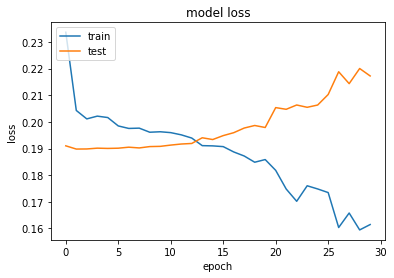

In [402]:
# summarize history for loss
plt.plot(lstm_reg_a_glove_history.history['loss'])
plt.plot(lstm_reg_a_glove_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model B: Word Vectors + 30min Price History as Inputs

### Method 1: Using Word2Vec word embedding

In [403]:
model_b_df = pd.read_csv('../data/data_LSTM_model_b.csv')
model_b_df.dropna(subset=['prev_30mins_prices', 'text_LSTM'], inplace=True)

X_lstm_reg_b = model_b_df.loc[:, ['text_LSTM', 'prev_30mins_prices']]
y_lstm_reg_b = model_b_df.loc[:, '60mins_price_diff_abs']

In [404]:
X_train_lstm_reg_b, X_test_lstm_reg_b, y_train_lstm_reg_b, y_test_lstm_reg_b = train_test_split(X_lstm_reg_b, y_lstm_reg_b, test_size=0.33, random_state=2020)

def parse_price_history(price_history):
    result = [float(i) for i in price_history.strip('[').strip(']').replace(' ', '').split(',')]
    return result

X_train_price_history = X_train_lstm_reg_b_w2v.iloc[:, 1].apply(parse_price_history)
X_train_price_history = np.stack(X_train_price_history)
X_train_price_history = X_train_price_history.reshape(X_train_price_history.shape[0], X_train_price_history.shape[1],1)

X_test_price_history = X_test_lstm_reg_b_w2v.iloc[:, 1].apply(parse_price_history)
X_test_price_history = np.stack(X_test_price_history)
X_test_price_history = X_test_price_history.reshape(X_test_price_history.shape[0], X_test_price_history.shape[1],1)

In [405]:
# Word2Vec has to be trained again as tweets before 8.30am are now removed (market opens at 8am, no stock prices before that)

# Add words into corpus list
lstm_reg_b_w2v_corpus_list = []

for i in X_train_lstm_reg_b.iloc[:,0]:
    lstm_reg_b_w2v_corpus_list.append(str(i).split())
    
# Train Word2Vec
lstm_reg_b_w2v_model = Word2Vec(lstm_reg_b_w2v_corpus_list, min_count=1, size=100)
lstm_reg_b_w2v_weights = lstm_reg_b_w2v_model.wv.vectors

# Find length of longest sentence (for padding later on)
lstm_reg_b_w2v_num_words = [len(i) for i in lstm_reg_b_w2v_corpus_list]
lstm_reg_b_w2v_longest_sentence_len = max(lstm_reg_b_w2v_num_words)

X_train_lstm_reg_b_w2v_padded = word2vec_sentence_to_indices_padded(X_train_lstm_reg_b.iloc[:,0], lstm_reg_b_w2v_longest_sentence_len, lstm_reg_b_w2v_model)
X_test_lstm_reg_b_w2v_padded = word2vec_sentence_to_indices_padded(X_test_lstm_reg_b.iloc[:,0], lstm_reg_b_w2v_longest_sentence_len, lstm_reg_b_w2v_model)

In [406]:
X_train_lstm_reg_b_w2v_input = [X_train_lstm_reg_b_w2v_padded, np.array(X_train_price_history)]
X_test_lstm_reg_b_w2v_input = [X_test_lstm_reg_b_w2v_padded, X_test_price_history]

In [407]:
def create_lstm_reg_b_w2v(pretrained_weights, longest_sentence_len, price_history_shape):
    vocab_size, embedding_size = pretrained_weights.shape
    
    # word vectors model
    model1_input = layers.Input(shape=longest_sentence_len, dtype='int32', name='sentence_index_input')
    model1 = layers.Embedding(input_dim=vocab_size, output_dim=embedding_size, weights=[pretrained_weights], trainable=False)(model1_input)  
    model1 = layers.LSTM(4, return_sequences=True, name='model1_LSTM1')(model1)
    model1 = layers.Dropout(0.25,name='model1_dropout1')(model1)
    model1 = layers.LSTM(4, return_sequences=False, name='model1_LSTM2')(model1)
    model1 = layers.Dropout(0.25,name='model1_dropout2')(model1)
    
    # price history model
    model2_input = layers.Input(shape=price_history_shape, dtype='float32', name='price_history_input')
    model2 = layers.LSTM(4, return_sequences=True, name='model2_LSTM1')(model2_input)
    model2 = layers.Dropout(0.25,name='model2_dropout1')(model2)
    model2 = layers.LSTM(4, return_sequences=False, name='model2_LSTM2')(model2)
    model2 = layers.Dropout(0.25,name='model2_dropout2')(model2)
    
    model_concat = layers.concatenate([model1, model2])
    model_concat = layers.Dense(4,name='Dense',activation='tanh')(model_concat)
    model_concat = layers.Dropout(0.1)(model_concat)
    model_concat = layers.Dense(1,activation='linear')(model_concat)
    
    model = keras.models.Model(inputs=[model1_input, model2_input], outputs = model_concat)
    
    return model

In [408]:
lstm_reg_b_w2v_ann = create_lstm_reg_b_w2v(lstm_reg_b_w2v_weights, lstm_reg_b_w2v_longest_sentence_len, (30, 1,))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
lstm_reg_b_w2v_ann.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae'])
lstm_reg_b_w2v_ann.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_index_input (InputLaye [(None, 162)]        0                                            
__________________________________________________________________________________________________
embedding_23 (Embedding)        (None, 162, 100)     417200      sentence_index_input[0][0]       
__________________________________________________________________________________________________
price_history_input (InputLayer [(None, 30, 1)]      0                                            
__________________________________________________________________________________________________
model1_LSTM1 (LSTM)             (None, 162, 4)       1680        embedding_23[0][0]               
___________________________________________________________________________________________

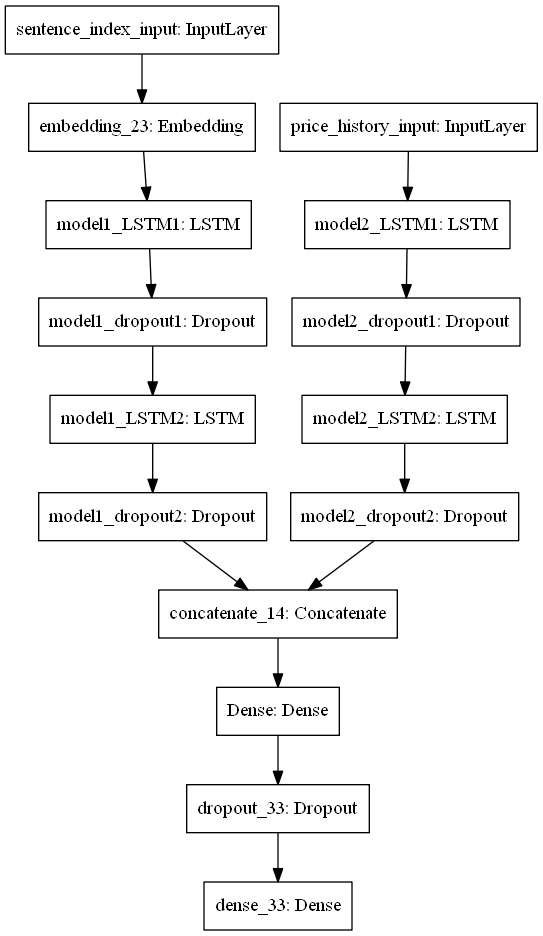

In [409]:
plot_model(
    lstm_reg_b_w2v_ann,
    to_file="../data/lstm_reg_b_w2v_ann.png",
    show_shapes=False,
    show_layer_names=True,
    rankdir="TB"
)

In [410]:
now = dt.datetime.now()
dt_string = now.strftime("%d%m%Y %H%Mh")

lstm_reg_b_w2v_checkpoint_filepath = f'../models/lstm_reg_b_w2v/lstm_reg_b_w2v_{dt_string}.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=lstm_reg_b_w2v_checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose = 1,
    save_best_only=True) 

lstm_reg_b_w2v_history = lstm_reg_b_w2v_ann.fit(X_train_lstm_reg_b_w2v_input, y_train_lstm_reg_b, validation_split=0.33, epochs=30, callbacks=[model_checkpoint_callback])

Train on 925 samples, validate on 457 samples
Epoch 1/30
896/925 [============================>.] - ETA: 0s - loss: 0.2356 - mae: 0.2948
Epoch 00001: val_loss improved from inf to 0.18789, saving model to ./lstm_reg_b_w2v/lstm_reg_b_w2v_20112020 1613h.h5
925/925 [==============================] - 11s 12ms/sample - loss: 0.2305 - mae: 0.2923 - val_loss: 0.1879 - val_mae: 0.2392
Epoch 2/30
896/925 [============================>.] - ETA: 0s - loss: 0.2162 - mae: 0.2748
Epoch 00002: val_loss improved from 0.18789 to 0.18461, saving model to ./lstm_reg_b_w2v/lstm_reg_b_w2v_20112020 1613h.h5
925/925 [==============================] - 3s 3ms/sample - loss: 0.2127 - mae: 0.2732 - val_loss: 0.1846 - val_mae: 0.2187
Epoch 3/30
896/925 [============================>.] - ETA: 0s - loss: 0.2070 - mae: 0.2521
Epoch 00003: val_loss did not improve from 0.18461
925/925 [==============================] - 3s 3ms/sample - loss: 0.2048 - mae: 0.2509 - val_loss: 0.1879 - val_mae: 0.2392
Epoch 4/30
896/925 

In [351]:
lstm_reg_b_w2v_ann_loaded = create_lstm_reg_b_w2v(lstm_reg_b_w2v_weights, lstm_reg_b_w2v_longest_sentence_len, (30,1,))
lstm_reg_b_w2v_ann_loaded.load_weights(lstm_reg_b_w2v_checkpoint_filepath)
lstm_reg_b_w2v_ann_loaded.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae'])

In [352]:
dev_loss, dev_acc = lstm_reg_b_w2v_ann_loaded.evaluate(X_test_lstm_reg_b_w2v_input, y_test_lstm_reg_b, verbose=1)

print(f"Training MSE: {np.sqrt(metrics.mean_squared_error(y_train_lstm_reg_b, lstm_reg_b_w2v_ann_loaded.predict(X_train_lstm_reg_b_w2v_input)))}")
print(f"Test MSE: {np.sqrt(metrics.mean_squared_error(y_test_lstm_reg_b, lstm_reg_b_w2v_ann_loaded.predict(X_test_lstm_reg_b_w2v_input)))}")
print(f"Test R^2: {metrics.r2_score(y_test_lstm_reg_b, lstm_reg_b_w2v_ann_loaded.predict(X_test_lstm_reg_b_w2v_input))}")
print(f"Baseline MSE: {np.sqrt(metrics.mean_squared_error(y_test_lstm_reg_b, 0*y_test_lstm_reg_b))}")

682/682 [==============================] - 2s 3ms/sample - loss: 0.1860 - mae: 0.2085
Training MSE: 0.4350762875556119
Test MSE: 0.43124441116935547
Test R^2: -0.009746501478841596
Baseline MSE: 0.4295480657197291


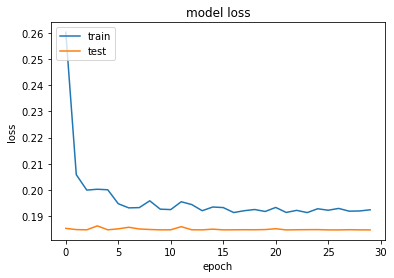

In [353]:
# summarize history for loss
plt.plot(lstm_reg_b_w2v_history.history['loss'])
plt.plot(lstm_reg_b_w2v_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Method 2: Using GloVe word embedding

In [411]:
dimension = 100
embeddings_index = {}
f = open(f'../data/glove/glove.twitter.27B.{dimension}d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train_lstm_reg_b.iloc[:,0]) # tweets used are same as Model B Word2Vec tweets
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1

#text to integers
sequences = tokenizer.texts_to_sequences(X_train_lstm_reg_b.iloc[:,0])
lstm_reg_b_glove_longest_sentence_len = 30
X_train_lstm_reg_b_glove_padded = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=lstm_reg_b_glove_longest_sentence_len, padding='pre')

print('Found %s unique tokens.' % len(word_index))

unique_words = set(word_index.keys())
def prepare_test_x_glove(x):
    global unique_words
    global word_index
    global lstm_reg_b_glove_longest_sentence_len
    
    result = []
    for tweet in x:
        indices = []
        for word in tweet.split():
            if word in unique_words:
                indices.append(word_index[word])
            else:
                indices.append(0)
            
        result.append(indices)
    return keras.preprocessing.sequence.pad_sequences(result, maxlen=lstm_reg_b_glove_longest_sentence_len, padding='pre')

X_test_lstm_reg_b_glove_padded = prepare_test_x_glove(X_test_lstm_reg_b.iloc[:,0])

Found 1193514 word vectors.
Found 4174 unique tokens.


In [412]:
X_train_lstm_reg_b_glove_input = [X_train_lstm_reg_b_glove_padded, np.array(X_train_price_history)]
X_test_lstm_reg_b_glove_input = [X_test_lstm_reg_b_glove_padded, X_test_price_history]

In [413]:
def create_lstm_reg_b_glove(longest_sentence_len, price_history_shape):
    global embedding_layer_glove
    # word vectors model
    model1_input = layers.Input(shape=longest_sentence_len, dtype='int32', name='sentence_index_input')
    model1 = embedding_layer_glove(model1_input)  
    model1 = layers.LSTM(4, return_sequences=True, name='model1_LSTM1')(model1)
    model1 = layers.Dropout(0.25,name='model1_dropout1')(model1)
    model1 = layers.LSTM(4, return_sequences=False, name='model1_LSTM2')(model1)
    model1 = layers.Dropout(0.25,name='model1_dropout2')(model1)
    
    # price history model
    model2_input = layers.Input(shape=price_history_shape, dtype='float32', name='price_history_input')
    model2 = layers.LSTM(4, return_sequences=True, name='model2_LSTM1')(model2_input)
    model2 = layers.Dropout(0.25,name='model2_dropout1')(model2)
    model2 = layers.LSTM(4, return_sequences=False, name='model2_LSTM2')(model2)
    model2 = layers.Dropout(0.25,name='model2_dropout2')(model2)
    
    model_concat = layers.concatenate([model1, model2])
    model_concat = layers.Dense(4,name='Dense',activation='tanh')(model_concat)
    model_concat = layers.Dropout(0.1)(model_concat)
    model_concat = layers.Dense(1,activation='linear')(model_concat)
    
    model = keras.models.Model(inputs=[model1_input, model2_input], outputs = model_concat)
    
    return model

In [414]:
lstm_reg_b_glove_ann = create_lstm_reg_b_glove(lstm_reg_b_glove_longest_sentence_len, (30,1,))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
lstm_reg_b_glove_ann.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae'])
lstm_reg_b_glove_ann.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_index_input (InputLaye [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 30, 100)      433700      sentence_index_input[0][0]       
__________________________________________________________________________________________________
price_history_input (InputLayer [(None, 30, 1)]      0                                            
__________________________________________________________________________________________________
model1_LSTM1 (LSTM)             (None, 30, 4)        1680        embedding_22[2][0]               
___________________________________________________________________________________________

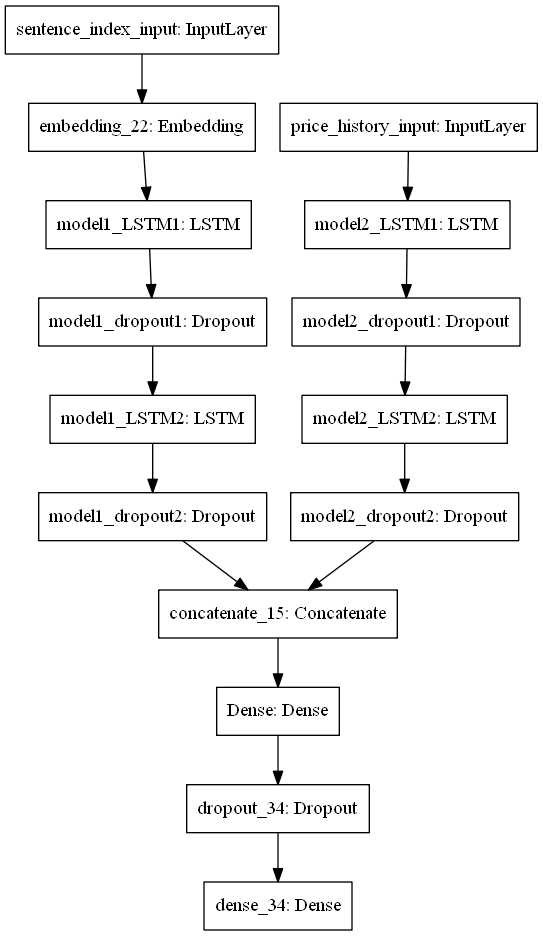

In [415]:
plot_model(
    lstm_reg_b_glove_ann,
    to_file="../data/lstm_reg_b_glove_ann.png",
    show_shapes=False,
    show_layer_names=True,
    rankdir="TB"
)

In [416]:
now = dt.datetime.now()
dt_string = now.strftime("%d%m%Y %H%Mh")

lstm_reg_b_glove_checkpoint_filepath = f'../models/lstm_reg_b_glove/lstm_reg_b_glove_{dt_string}.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=lstm_reg_b_glove_checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose = 1,
    save_best_only=True) 

lstm_reg_b_glove_history = lstm_reg_b_glove_ann.fit(X_train_lstm_reg_b_glove_input, y_train_lstm_reg_b, validation_split=0.33, epochs=30, callbacks=[model_checkpoint_callback])

Train on 925 samples, validate on 457 samples
Epoch 1/30
864/925 [===========================>..] - ETA: 0s - loss: 0.1823 - mae: 0.2467
Epoch 00001: val_loss improved from inf to 0.18550, saving model to ./lstm_reg_b_glove/lstm_reg_b_glove_20112020 1616h.h5
925/925 [==============================] - 9s 9ms/sample - loss: 0.2022 - mae: 0.2462 - val_loss: 0.1855 - val_mae: 0.2192
Epoch 2/30
864/925 [===========================>..] - ETA: 0s - loss: 0.2007 - mae: 0.2330
Epoch 00002: val_loss improved from 0.18550 to 0.18531, saving model to ./lstm_reg_b_glove/lstm_reg_b_glove_20112020 1616h.h5
925/925 [==============================] - 1s 771us/sample - loss: 0.1934 - mae: 0.2296 - val_loss: 0.1853 - val_mae: 0.2181
Epoch 3/30
896/925 [============================>.] - ETA: 0s - loss: 0.1981 - mae: 0.2296
Epoch 00003: val_loss improved from 0.18531 to 0.18531, saving model to ./lstm_reg_b_glove/lstm_reg_b_glove_20112020 1616h.h5
925/925 [==============================] - 1s 775us/sample 

In [417]:
lstm_reg_b_glove_ann_loaded = create_lstm_reg_b_glove(lstm_reg_b_glove_longest_sentence_len, (30,1,))
lstm_reg_b_glove_ann_loaded.load_weights(lstm_reg_b_glove_checkpoint_filepath)
lstm_reg_b_glove_ann_loaded.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae'])

In [418]:
dev_loss, dev_acc = lstm_reg_b_glove_ann_loaded.evaluate(X_test_lstm_reg_b_glove_input, y_test_lstm_reg_b, verbose=1)

print(f"Training MSE: {np.sqrt(metrics.mean_squared_error(y_train_lstm_reg_b, lstm_reg_b_glove_ann_loaded.predict(X_train_lstm_reg_b_glove_input)))}")
print(f"Test MSE: {np.sqrt(metrics.mean_squared_error(y_test_lstm_reg_b, lstm_reg_b_glove_ann_loaded.predict(X_test_lstm_reg_b_glove_input)))}")
print(f"Test R^2: {metrics.r2_score(y_test_lstm_reg_b, lstm_reg_b_glove_ann_loaded.predict(X_test_lstm_reg_b_glove_input))}")
print(f"Baseline MSE: {np.sqrt(metrics.mean_squared_error(y_test_lstm_reg_b, 0*y_test_lstm_reg_b))}")

682/682 [==============================] - 2s 3ms/sample - loss: 0.1866 - mae: 0.2117
Training MSE: 0.4320179122916018
Test MSE: 0.4319888794556886
Test R^2: -0.013235813286825548
Baseline MSE: 0.4295480657197291


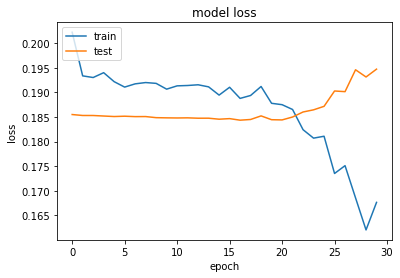

In [419]:
# summarize history for loss
plt.plot(lstm_reg_b_glove_history.history['loss'])
plt.plot(lstm_reg_b_glove_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 2. Classification

## Method 1: Word-Based

In [420]:
### get the range of the absolute diff in price change after tweet

In [75]:
min(master_df.loc[:,"60mins_price_diff_abs"])

-3.989999999999952

In [76]:
max(master_df.loc[:,"60mins_price_diff_abs"])

2.9699999999999704

In [77]:
# Add a target column for the y label {-1,0,1}

In [78]:
target_value = []

for i in range(0, len(master_df)):
    
    if master_df.loc[i,'60mins_price_diff_abs'] >= 0.020000:
        target_value.append(1)

    elif master_df.loc[i,'60mins_price_diff_abs'] <= -0.003393:
        target_value.append(-1)

    else:
        target_value.append(0)

In [79]:
classification_df = master_df.copy()
classification_df.loc[:, 'target'] = target_value

In [80]:
# Drop missing values before fitting the models
classification_df.dropna(inplace=True)

In [81]:
# Define the x and y variables
X_classification = classification_df.text_LSTM
y_classification = classification_df.target

In [82]:
# Train-test split for classification tasks
X_train_classification , X_test_classification, y_train_classification, y_test_classification = train_test_split(X_classification, y_classification, test_size=0.33, random_state=2020)

In [83]:
# Get an understanding of the class distribution in training and test

In [84]:
y_train.value_counts()

 1    737
-1    737
 0    737
Name: target, dtype: int64

In [85]:
y_test.value_counts()

 1    196
-1    165
 0     89
Name: target, dtype: int64

### Naive Bayes

In [90]:
#Naive-Bayes classification
#more no. of features doesnt seem to improve accuracy after 5000
#better results using cv + tfidftrransformer
pipe1_ = Pipeline([('vect', CountVectorizer(stop_words="english",max_features=1000)), ('tfidf', TfidfTransformer()), ('model1', MultinomialNB())])
#pipe3 = Pipeline([('vect', CountVectorizer(stop_words="english")),  ('model', MultinomialNB())])
model_nb1 = pipe1_.fit(X_train_classification, y_train_classification)
nb_pred1 = model_nb1.predict(X_test_classification)

print("Accuracy of Naive Bayes Classifier: {}%".format(round(accuracy_score(y_test_classification, nb_pred1)*100,2)))
print("\nConfusion Matrix of Naive Bayes Classifier:\n")
print(confusion_matrix(y_test_classification, nb_pred1))
print("\nClassification Report of Naive Bayes Classifier:\n")
print(classification_report(y_test_classification, nb_pred1))

Accuracy of Naive Bayes Classifier: 41.05%

Confusion Matrix of Naive Bayes Classifier:

[[163   3 116]
 [ 71   2  69]
 [166   3 133]]

Classification Report of Naive Bayes Classifier:

              precision    recall  f1-score   support

          -1       0.41      0.58      0.48       282
           0       0.25      0.01      0.03       142
           1       0.42      0.44      0.43       302

    accuracy                           0.41       726
   macro avg       0.36      0.34      0.31       726
weighted avg       0.38      0.41      0.37       726



In [91]:
param_grid = {
    'model1__alpha' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}


# Instantiate the grid search model
grid_search = GridSearchCV(pipe1_, 
                           n_jobs = -1,cv = 3,param_grid=param_grid, verbose = 2, scoring = 'f1_weighted')

# Fit the grid search to the data
grid_search.fit(X_train_classification, y_train_classification)

print(grid_search.best_params_)
print()

best_grid = grid_search.best_estimator_

def evaluate(model, test_features, test_labels):
    y_pred = model.predict(test_features)
    accuracy = accuracy_score(y_test_classification, y_pred)
    print('Accuracy:', accuracy * 100)
    print()
    print('Confusion Matrix:\n', confusion_matrix(y_test_classification, y_pred))
    print()
    print('Classification Report:\n', classification_report(y_test_classification, y_pred))

evaluate(best_grid, X_test_classification, y_test_classification)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'model1__alpha': 0.01}

Accuracy: 40.77134986225895

Confusion Matrix:
 [[152  22 108]
 [ 67  16  59]
 [157  17 128]]

Classification Report:
               precision    recall  f1-score   support

          -1       0.40      0.54      0.46       282
           0       0.29      0.11      0.16       142
           1       0.43      0.42      0.43       302

    accuracy                           0.41       726
   macro avg       0.38      0.36      0.35       726
weighted avg       0.39      0.41      0.39       726



[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.2s finished


### Logistic Regression

Method 1: Text-Based

In [439]:
#Logistic regression classification
pipe2_ = Pipeline([('vect', CountVectorizer(stop_words="english", min_df=3, ngram_range=(1,1), max_features=200)), ('tfidf', TfidfTransformer()), ('model2', LogisticRegression())])
#models must be in the correct order, where previous models must have fit and transform functionality while 
#last model must only have fit
model_lr1 = pipe2_.fit(X_train_classification, y_train_classification)
lr_pred1 = model_lr1.predict(X_test_classification)

print("Accuracy of Logistic Regression Classifier: {}%".format(round(accuracy_score(y_test_classification, lr_pred1)*100,2)))
print("\nConfusion Matrix of Logistic Regression Classifier:\n")
print(confusion_matrix(y_test_classification, lr_pred1))
print("\nCLassification Report of Logistic Regression Classifier:\n")
print(classification_report(y_test_classification, lr_pred1))

Accuracy of Logistic Regression Classifier: 39.81%

Confusion Matrix of Logistic Regression Classifier:

[[148  15 119]
 [ 69   8  65]
 [151  18 133]]

CLassification Report of Logistic Regression Classifier:

              precision    recall  f1-score   support

          -1       0.40      0.52      0.46       282
           0       0.20      0.06      0.09       142
           1       0.42      0.44      0.43       302

    accuracy                           0.40       726
   macro avg       0.34      0.34      0.32       726
weighted avg       0.37      0.40      0.37       726



In [440]:
param_grid = {
    'model2__penalty': ['l1', 'l2'],
    'model2__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'model2__solver': ['newton-cg', 'lbfgs'],
    'model2__max_iter': [500, 1000],
    'model2__multi_class': ['auto', 'multinomial']
}


# Instantiate the grid search model
grid_search = GridSearchCV(pipe2_, 
                           n_jobs = -1,cv=3,param_grid=param_grid, verbose = 2, scoring = 'f1_weighted')

# Fit the grid search to the data
grid_search.fit(X_train_classification, y_train_classification)

print(grid_search.best_params_)
print()

best_grid = grid_search.best_estimator_

def evaluate(model, test_features, test_labels):
    y_pred = model.predict(test_features)
    accuracy = accuracy_score(y_test_classification, y_pred)
    print('Accuracy:', accuracy * 100)
    print()
    print('Confusion Matrix:\n', confusion_matrix(y_test_classification, y_pred))
    print()
    print('Classification Report:\n', classification_report(y_test_classification, y_pred))

evaluate(best_grid, X_test_classification, y_test_classification)

Fitting 3 folds for each of 112 candidates, totalling 336 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 329 out of 336 | elapsed:    6.6s remaining:    0.0s


{'model2__C': 10, 'model2__max_iter': 500, 'model2__multi_class': 'auto', 'model2__penalty': 'l2', 'model2__solver': 'newton-cg'}

Accuracy: 38.84297520661157

Confusion Matrix:
 [[135  34 113]
 [ 60  24  58]
 [140  39 123]]

Classification Report:
               precision    recall  f1-score   support

          -1       0.40      0.48      0.44       282
           0       0.25      0.17      0.20       142
           1       0.42      0.41      0.41       302

    accuracy                           0.39       726
   macro avg       0.36      0.35      0.35       726
weighted avg       0.38      0.39      0.38       726



[Parallel(n_jobs=-1)]: Done 336 out of 336 | elapsed:    6.9s finished


## Random Forest

Method 1: Text-Based

In [442]:
#Random Forest classification
pipe3_ = Pipeline([('vect', CountVectorizer(stop_words="english", min_df=3, ngram_range=(1,1), max_features=200)), ('tfidf', TfidfTransformer()), ('model3', RandomForestClassifier())])
#models must be in the correct order, where previous models must have fit and transform functionality while 
#last model must only have fit
model_lr1 = pipe3_.fit(X_train_classification, y_train_classification)
lr_pred1 = model_lr1.predict(X_test_classification)

print("Accuracy of Logistic Regression Classifier: {}%".format(round(accuracy_score(y_test_classification, lr_pred1)*100,2)))
print("\nConfusion Matrix of Logistic Regression Classifier:\n")
print(confusion_matrix(y_test_classification, lr_pred1))
print("\nCLassification Report of Logistic Regression Classifier:\n")
print(classification_report(y_test_classification, lr_pred1))

Accuracy of Logistic Regression Classifier: 38.15%

Confusion Matrix of Logistic Regression Classifier:

[[141  32 109]
 [ 66  10  66]
 [149  27 126]]

CLassification Report of Logistic Regression Classifier:

              precision    recall  f1-score   support

          -1       0.40      0.50      0.44       282
           0       0.14      0.07      0.09       142
           1       0.42      0.42      0.42       302

    accuracy                           0.38       726
   macro avg       0.32      0.33      0.32       726
weighted avg       0.36      0.38      0.36       726



In [443]:
pipe3_.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'model3', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'model3__bootstrap', 'model3__ccp_alpha', 'model3__class_weight', 'model3__criterion', 'model3__max_depth', 'model3__max_features', 'model3__max_leaf_nodes', 'model3__max_samples', 'model3__min_impurity_decrease', 'model3__min_impurity_split', 'model3__min_samples_leaf', 'model3__min_samples_split', 'model3__min_weight_fraction_leaf', 'model3__n_estimators', 'model3__n_jobs', 'model3__oob_score', 'model3__random_state', 'model3__verbose', 'model3__warm_start'])

In [445]:
param_grid = {
    'model3__bootstrap': [True],
    'model3__max_leaf_nodes':[4,5,6],
    'model3__max_depth': [10,15],
    'model3__max_features': [2, 3],
    'model3__min_samples_leaf': [3, 4, 5, 6],
    #'model3__min_samples_split': [3, 4, 5, 6],
    'model3__n_estimators': [1000, 1300]
}

# Instantiate the grid search model
grid_search = GridSearchCV(pipe3_, 
                           n_jobs = -1,cv=3,param_grid=param_grid, verbose = 2, scoring = 'f1_weighted')

# Fit the grid search to the data
grid_search.fit(X_train_classification, y_train_classification)

print(grid_search.best_params_)
print()

best_grid = grid_search.best_estimator_

def evaluate(model, test_features, test_labels):
    y_pred = model.predict(test_features)
    accuracy = accuracy_score(y_test_classification, y_pred)
    print('Accuracy:', accuracy * 100)
    print()
    print('Confusion Matrix:\n', confusion_matrix(y_test_classification, y_pred))
    print()
    print('Classification Report:\n', classification_report(y_test_classification, y_pred))

evaluate(best_grid, X_test_classification, y_test_classification)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  2.9min finished


{'model3__bootstrap': True, 'model3__max_depth': 15, 'model3__max_features': 3, 'model3__max_leaf_nodes': 6, 'model3__min_samples_leaf': 6, 'model3__n_estimators': 1300}

Accuracy: 39.11845730027548

Confusion Matrix:
 [[223   0  59]
 [104   0  38]
 [241   0  61]]

Classification Report:
               precision    recall  f1-score   support

          -1       0.39      0.79      0.52       282
           0       0.00      0.00      0.00       142
           1       0.39      0.20      0.27       302

    accuracy                           0.39       726
   macro avg       0.26      0.33      0.26       726
weighted avg       0.31      0.39      0.31       726



C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Support Vector Machine (SVM)

Method 1: Text-Based

In [446]:
#Support Vector classification
#accuracy score is better without applying the TFIDFTRANSFORMER()
pipe4_ = Pipeline([('vect', CountVectorizer(stop_words="english")), ('tfidf', TfidfTransformer()), ('model4', SVC())])
#pipe2 = Pipeline([('vect', CountVectorizer(stop_words="english")),  ('model', LinearSVC())])
model_svc1 = pipe4_.fit(X_train_classification, y_train_classification)
svc_pred1 = model_svc1.predict(X_test_classification)

print("Accuracy of SVM Classifier: {}%".format(round(accuracy_score(y_test_classification, svc_pred1)*100,2)))
print("\nConfusion Matrix of SVM Classifier:\n")
print(confusion_matrix(y_test_classification, svc_pred1))
print("\nClassification Report of SVM Classifier:\n")
print(classification_report(y_test_classification, svc_pred1))

Accuracy of SVM Classifier: 40.22%

Confusion Matrix of SVM Classifier:

[[186   4  92]
 [ 85   1  56]
 [196   1 105]]

Classification Report of SVM Classifier:

              precision    recall  f1-score   support

          -1       0.40      0.66      0.50       282
           0       0.17      0.01      0.01       142
           1       0.42      0.35      0.38       302

    accuracy                           0.40       726
   macro avg       0.33      0.34      0.30       726
weighted avg       0.36      0.40      0.35       726



In [447]:
pipe4_.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'model4', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'model4__C', 'model4__break_ties', 'model4__cache_size', 'model4__class_weight', 'model4__coef0', 'model4__decision_function_shape', 'model4__degree', 'model4__gamma', 'model4__kernel', 'model4__max_iter', 'model4__probability', 'model4__random_state', 'model4__shrinking', 'model4__tol', 'model4__verbose'])

In [92]:
param_grid = {
    'model4__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'model4__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'model4__gamma': ['scale', 'auto']
}
grid_search = GridSearchCV(pipe4_, 
                           n_jobs = -1,cv=3,param_grid=param_grid, verbose = 2, scoring = 'f1_weighted')

# Fit the grid search to the data
grid_search.fit(X_train_classification, y_train_classification)

print(grid_search.best_params_)
print()

best_grid = grid_search.best_estimator_

def evaluate(model, test_features, test_labels):
    y_pred = model.predict(test_features)
    accuracy = accuracy_score(y_test_classification, y_pred)
    print('Accuracy:', accuracy * 100)
    print()
    print('Confusion Matrix:\n', confusion_matrix(y_test_classification, y_pred))
    print()
    print('Classification Report:\n', classification_report(y_test_classification, y_pred))

evaluate(best_grid, X_test_classification, y_test_classification)

Fitting 3 folds for each of 56 candidates, totalling 168 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    7.9s finished


{'model4__C': 10, 'model4__gamma': 'scale', 'model4__kernel': 'sigmoid'}

Accuracy: 35.26170798898072

Confusion Matrix:
 [[129  47 106]
 [ 57  31  54]
 [140  66  96]]

Classification Report:
               precision    recall  f1-score   support

          -1       0.40      0.46      0.42       282
           0       0.22      0.22      0.22       142
           1       0.38      0.32      0.34       302

    accuracy                           0.35       726
   macro avg       0.33      0.33      0.33       726
weighted avg       0.35      0.35      0.35       726



## Light Gradient Boosting Machine

In [93]:
#LightGBM classification

pipe5_ = Pipeline([('vect', CountVectorizer(stop_words="english")), ('tfidf', TfidfTransformer()), ('model5', LGBMClassifier(boosting_type='gbdt',  objective='multiclass', random_state=0, n_jobs=-1))])
#pipe2 = Pipeline([('vect', CountVectorizer(stop_words="english")),  ('model', LinearSVC())])
model_lgb1 = pipe5_.fit(X_train_classification, y_train_classification)
lgb_pred1 = model_lgb1.predict(X_test_classification)

print("Accuracy of LGBM Classifier: {}%".format(round(accuracy_score(y_test_classification, svc_pred1)*100,2)))
print("\nConfusion Matrix of LGBM Classifier:\n")
print(confusion_matrix(y_test_classification, lgb_pred1))
print("\nClassification Report of LGBM Classifier:\n")
print(classification_report(y_test_classification, lgb_pred1))

Accuracy of LGBM Classifier: 40.22%

Confusion Matrix of LGBM Classifier:

[[145  38  99]
 [ 62  22  58]
 [148  31 123]]

Classification Report of LGBM Classifier:

              precision    recall  f1-score   support

          -1       0.41      0.51      0.46       282
           0       0.24      0.15      0.19       142
           1       0.44      0.41      0.42       302

    accuracy                           0.40       726
   macro avg       0.36      0.36      0.36       726
weighted avg       0.39      0.40      0.39       726



In [94]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'model5__num_leaves': [31, 127],
    'model5__reg_alpha': [0.1, 0.5],
    'model5__min_data_in_leaf': [10, 20, 30, 50, 100, 300, 400],
    'model5__lambda_l1': [0.1, 1, 1.5],
    'model5__lambda_l2': [0.0, 1]
}

# Instantiate the grid search model
grid_search = GridSearchCV(pipe5_, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring = 'f1_weighted')

# Fit the grid search to the data
grid_search.fit(X_train_classification, y_train_classification)

print(grid_search.best_params_)

best_grid = grid_search.best_estimator_

evaluate(best_grid, X_test_classification, y_test_classification)

Fitting 3 folds for each of 168 candidates, totalling 504 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 504 out of 504 | elapsed:   24.4s finished


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
{'model5__lambda_l1': 0.1, 'model5__lambda_l2': 0.0, 'model5__min_data_in_leaf': 20, 'model5__num_leaves': 127, 'model5__reg_alpha': 0.1}
Accuracy: 39.94490358126722

Confusion Matrix:
 [[144  36 102]
 [ 63  22  57]
 [140  38 124]]

Classification Report:
               precision    recall  f1-score   support

          -1       0.41      0.51      0.46       282
           0       0.23      0.15      0.18       142
           1       0.44      0.41      0.42       302

    accuracy                           0.40       726
   macro avg       0.36      0.36      0.36       726
weighted avg       0.39      0.40      0.39       726



In [36]:
df2 = master_df.copy()

In [37]:
print(df2.columns.get_loc("60mins_price_diff_abs"))
print(df2.columns.get_loc("hour"))
print(df2.columns.get_loc("compound"))

15
8
23


In [38]:
#creates a list of values for the y label for each row
target_value = []

for i in range(0, len(df2)):
    
    if df2.iloc[i, 15] >= 0.020000:
        target_value.append(1)

    elif df2.iloc[i, 15] <= -0.003393:
        target_value.append(-1)

    else:
        target_value.append(0)
    

In [39]:
compound_group = []

for i in range(0, len(df2)):
    
    if df2.iloc[i, 23] >= 0.6:
        compound_group.append(15)
        
    elif df2.iloc[i, 23] >= 0.1:
        compound_group.append(14)
      
    elif df2.iloc[i, 23] > -0.1 and df2.iloc[i, 23] < 0.1:
        compound_group.append(13)
        
    elif df2.iloc[i, 23] <= -0.6:
        compound_group.append(11)
    
    elif df2.iloc[i, 23] <= -0.1:
        compound_group.append(12)

In [40]:
hours_grouped = []

for i in range(0, len(df2)):
    
    if df2.iloc[i, 8] >= 16:
        hours_grouped.append(20)
        
    elif df2.iloc[i, 8] >= 12:
        hours_grouped.append(19)
        
    else:
        hours_grouped.append(18)

In [41]:
#create a column for the y_label 
df2.loc[:, 'hours_grouped'] = hours_grouped
df2.loc[:, 'target'] = target_value
df2.loc[:, 'compound_group'] = compound_group

In [42]:
#to verify that there are no NA values
df2.isna().sum()

id                          0
text                        0
favorites                   0
retweets                    0
date                        0
tweet_datetime              0
date_part                   0
time_part                   0
hour                        0
year                        0
month                       0
text_topic_modelling       49
text_EDA                    0
text_sentiment_analysis    34
text_LSTM                  46
60mins_price_diff_abs       0
60mins_price_diff_perc      0
45mins_price_diff_abs       0
45mins_price_diff_perc      0
30mins_price_diff_abs       0
30mins_price_diff_perc      0
15mins_price_diff_abs       0
15mins_price_diff_perc      0
compound                    0
topic                       0
hours_grouped               0
target                      0
compound_group              0
dtype: int64

In [43]:
df2 = df2[['topic', 'compound_group', 'hours_grouped', 'target']]

comp = pd.get_dummies(df2['compound_group'])
topic = pd.get_dummies(df2['topic'])
hrs = pd.get_dummies(df2['hours_grouped'])
# Drop column as it is now encoded
df2 = df2.drop(['compound_group'], axis = 1)
df2 = df2.drop(['topic'], axis = 1)
df2 = df2.drop(['hours_grouped'], axis = 1)
# Join the encoded df
df2 = df2.join(comp)
df2 = df2.join(topic)
df2 = df2.join(hrs)
df2

,target,11,12,13,14,15,0,1,2,3,4,5,6,7,8,9,18,19,20
0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2241,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
2242,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2243,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0
2244,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [44]:
X = df2.iloc[:, 1:]
y = df2.target

In [45]:
#Train-test split
#test size is 20% of the dataset
x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [46]:
smote = SMOTE(random_state=0, sampling_strategy='not majority')
x_train, y_train = smote.fit_sample(x_train, y_train)

In [47]:
x_train[x_train > 1] = 1

## Naive Bayes

In [16]:
clf = MultinomialNB()
model = clf.fit(x_train, y_train)

y_pred = model.predict(x_test)

print("Accuracy of Naive Bayes Classifier: {}%".format(round(accuracy_score(y_test, y_pred)*100,2)))
print("\nConfusion Matrix of Naive Bayes Classifier:\n")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report of Naive Bayes Classifier:\n")
print(classification_report(y_test, y_pred))

Accuracy of Naive Bayes Classifier: 32.44%

Confusion Matrix of Naive Bayes Classifier:

[[75 69 21]
 [42 37 10]
 [84 78 34]]

Classification Report of Naive Bayes Classifier:

              precision    recall  f1-score   support

          -1       0.37      0.45      0.41       165
           0       0.20      0.42      0.27        89
           1       0.52      0.17      0.26       196

    accuracy                           0.32       450
   macro avg       0.37      0.35      0.31       450
weighted avg       0.40      0.32      0.32       450



In [21]:
# Create the parameter grid 
param_grid = {
    'alpha' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}
# Create a based model
nb = MultinomialNB()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = nb, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring = 'f1_weighted')

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

print(grid_search.best_params_)
print()

best_grid = grid_search.best_estimator_

def evaluate(model, test_features, test_labels):
    y_pred = model.predict(test_features)
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy:', accuracy * 100)
    print()
    print('Confusion Matrix:\n', confusion_matrix(y_test,y_pred))
    print()
    print('Classification Report:\n', classification_report(y_test, y_pred))

evaluate(best_grid,x_test,y_test)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'alpha': 10}

Accuracy: 33.111111111111114

Confusion Matrix:
 [[75 69 21]
 [42 35 12]
 [82 75 39]]

Classification Report:
               precision    recall  f1-score   support

          -1       0.38      0.45      0.41       165
           0       0.20      0.39      0.26        89
           1       0.54      0.20      0.29       196

    accuracy                           0.33       450
   macro avg       0.37      0.35      0.32       450
weighted avg       0.41      0.33      0.33       450



[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:    2.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    2.4s finished


## Logistic Regression

In [17]:
logr = LogisticRegression()
model = logr.fit(x_train, y_train)

y_pred = model.predict(x_test)

print("Accuracy of Logistic Regression Classifier: {}%".format(round(accuracy_score(y_test, y_pred)*100,2)))
print("\nConfusion Matrix of Logistic Regression Classifier:\n")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report of Logistic Regression Classifier:\n")
print(classification_report(y_test, y_pred))

Accuracy of Logistic Regression Classifier: 32.67%

Confusion Matrix of Logistic Regression Classifier:

[[73 63 29]
 [42 32 15]
 [83 71 42]]

Classification Report of Logistic Regression Classifier:

              precision    recall  f1-score   support

          -1       0.37      0.44      0.40       165
           0       0.19      0.36      0.25        89
           1       0.49      0.21      0.30       196

    accuracy                           0.33       450
   macro avg       0.35      0.34      0.32       450
weighted avg       0.39      0.33      0.33       450



In [22]:
# Create the parameter grid  
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs'],
    'max_iter': [500, 1000],
    'multi_class': ['auto', 'multinomial']
}
# Create a based model
lr = LogisticRegression()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = lr, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring = 'f1_weighted')

# Fit the grid search to the data
grid_search.fit(x_train,y_train)

print(grid_search.best_params_)
print()

best_grid = grid_search.best_estimator_

evaluate(best_grid,x_test,y_test)

Fitting 3 folds for each of 112 candidates, totalling 336 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


{'C': 0.1, 'max_iter': 500, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'newton-cg'}

Accuracy: 33.111111111111114

Confusion Matrix:
 [[68 61 36]
 [41 32 16]
 [76 71 49]]

Classification Report:
               precision    recall  f1-score   support

          -1       0.37      0.41      0.39       165
           0       0.20      0.36      0.25        89
           1       0.49      0.25      0.33       196

    accuracy                           0.33       450
   macro avg       0.35      0.34      0.32       450
weighted avg       0.38      0.33      0.34       450



[Parallel(n_jobs=-1)]: Done 321 out of 336 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 336 out of 336 | elapsed:    1.2s finished


## Support Vector Machine

In [18]:
clf = SVC()
model = clf.fit(x_train, y_train)

y_pred = model.predict(x_test)

print("Accuracy of SVC Classifier: {}%".format(round(accuracy_score(y_test, y_pred)*100,2)))
print("\nConfusion Matrix of SVC Classifier:\n")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report of SVC Classifier:\n")
print(classification_report(y_test, y_pred))

Accuracy of SVC Classifier: 33.33%

Confusion Matrix of SVC Classifier:

[[68 59 38]
 [38 26 25]
 [82 58 56]]

Classification Report of SVC Classifier:

              precision    recall  f1-score   support

          -1       0.36      0.41      0.39       165
           0       0.18      0.29      0.22        89
           1       0.47      0.29      0.36       196

    accuracy                           0.33       450
   macro avg       0.34      0.33      0.32       450
weighted avg       0.37      0.33      0.34       450



In [24]:
# Create the parameter grid
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}
# Create a based model
svc = SVC()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = svc, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring = 'f1_weighted')

# Fit the grid search to the data
grid_search.fit(x_train,y_train)

print(grid_search.best_params_)

best_grid = grid_search.best_estimator_

evaluate(best_grid,x_test,y_test)

Fitting 3 folds for each of 56 candidates, totalling 168 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 153 out of 168 | elapsed:    3.6s remaining:    0.3s


{'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
Accuracy: 33.55555555555556

Confusion Matrix:
 [[68 56 41]
 [37 25 27]
 [84 54 58]]

Classification Report:
               precision    recall  f1-score   support

          -1       0.36      0.41      0.38       165
           0       0.19      0.28      0.22        89
           1       0.46      0.30      0.36       196

    accuracy                           0.34       450
   macro avg       0.34      0.33      0.32       450
weighted avg       0.37      0.34      0.34       450



[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    4.0s finished


## Random Forest Classifier

In [19]:
clf = RandomForestClassifier()
model = clf.fit(x_train, y_train)

y_pred = model.predict(x_test)

print("Accuracy of Random Forest Classifier: {}%".format(round(accuracy_score(y_test, y_pred)*100,2)))
print("\nConfusion Matrix of Random Forest Classifier:\n")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report of Random Forest Classifier:\n")
print(classification_report(y_test, y_pred))

Accuracy of Random Forest Classifier: 33.56%

Confusion Matrix of Random Forest Classifier:

[[66 52 47]
 [35 29 25]
 [85 55 56]]

Classification Report of Random Forest Classifier:

              precision    recall  f1-score   support

          -1       0.35      0.40      0.38       165
           0       0.21      0.33      0.26        89
           1       0.44      0.29      0.35       196

    accuracy                           0.34       450
   macro avg       0.34      0.34      0.33       450
weighted avg       0.36      0.34      0.34       450



In [23]:
# Create the parameter grid  
param_grid = {
    'bootstrap': [True],
    'max_depth': [10,15],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5, 6],
    'min_samples_split': [3, 4, 5, 6],
    'n_estimators': [1000, 1300]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring = 'f1_weighted')

# Fit the grid search to the data
grid_search.fit(x_train,y_train)

print(grid_search.best_params_)

best_grid = grid_search.best_estimator_

evaluate(best_grid,x_test,y_test)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:  4.7min finished


{'bootstrap': True, 'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1000}
Accuracy: 32.88888888888889

Confusion Matrix:
 [[66 57 42]
 [37 26 26]
 [80 60 56]]

Classification Report:
               precision    recall  f1-score   support

          -1       0.36      0.40      0.38       165
           0       0.18      0.29      0.22        89
           1       0.45      0.29      0.35       196

    accuracy                           0.33       450
   macro avg       0.33      0.33      0.32       450
weighted avg       0.36      0.33      0.34       450



## Light Gradient Boosting Machine

In [20]:
classifier = LGBMClassifier(objective='multiclass', random_state=0, n_jobs=-1)
classifier.fit(x_train, y_train)

y_pred = classifier.predict(x_test)

print("Accuracy of Light Gradient Boosting Method Classifier: {}%".format(round(accuracy_score(y_test, y_pred)*100,2)))
print("\nConfusion Matrix of Light Gradient Boosting Method Classifier:\n")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report of Light Gradient Boosting Method Classifier:\n")
print(classification_report(y_test, y_pred))

Accuracy of Light Gradient Boosting Method Classifier: 33.33%

Confusion Matrix of Light Gradient Boosting Method Classifier:

[[65 57 43]
 [34 31 24]
 [83 59 54]]

Classification Report of Light Gradient Boosting Method Classifier:

              precision    recall  f1-score   support

          -1       0.36      0.39      0.37       165
           0       0.21      0.35      0.26        89
           1       0.45      0.28      0.34       196

    accuracy                           0.33       450
   macro avg       0.34      0.34      0.33       450
weighted avg       0.37      0.33      0.34       450



In [25]:
# Create the parameter grid  
param_grid = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [10, 20, 30, 50, 100, 300, 400],
    'lambda_l1': [0.1, 1, 1.5],
    'lambda_l2': [0.0, 1]
}
# Create a based model
lgbm = LGBMClassifier(boosting_type='gbdt',  objective='multiclass', random_state=0, n_jobs=-1)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = lgbm, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring = 'f1_weighted')

# Fit the grid search to the data
grid_search.fit(x_train,y_train)

print(grid_search.best_params_)

best_grid = grid_search.best_estimator_

evaluate(best_grid,x_test,y_test)

Fitting 3 folds for each of 168 candidates, totalling 504 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:    3.8s


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
{'lambda_l1': 0.1, 'lambda_l2': 0.0, 'min_data_in_leaf': 10, 'num_leaves': 31, 'reg_alpha': 0.1}
Accuracy: 34.88888888888889

Confusion Matrix:
 [[66 56 43]
 [34 28 27]
 [78 55 63]]

Classification Report:
               precision    recall  f1-score   support

          -1       0.37      0.40      0.38       165
           0       0.20      0.31      0.25        89
           1       0.47      0.32      0.38       196

    accuracy                           0.35       450
   macro avg       0.35      0.35      0.34       450
weighted avg       0.38      0.35      0.36       450



[Parallel(n_jobs=-1)]: Done 504 out of 504 | elapsed:    7.2s finished


## Artificial Neural Network (ANN)

In [48]:
X_train_ann, y_train_ann, X_test_ann, y_test_ann = x_train, y_train, x_test, y_test 

class_labels = [-1, 0, 1]
y_train_ann = y_train_ann.apply(lambda x: class_labels.index(x))
y_test_ann = y_test_ann.apply(lambda x: class_labels.index(x))

In [49]:
def create_ann_model(optimizer, activation, dropout_rate, neurons1, neurons2):
    # create model
    model = tf.keras.Sequential()
    model.add(layers.Dense(neurons1, input_dim=len(X_train_ann.columns), activation=activation))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(neurons2, activation=activation))
    model.add(layers.Dense(3))
    # Compile model
    
    model.compile(optimizer=optimizer,
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_ann_model, epochs=30)

# define the grid search parameters
optimizer = ['SGD', 'Adam']
activation = ['softmax', 'relu', 'tanh', 'sigmoid']
dropout_rate = [0.0, 0.1, 0.2]
neurons1 = [8, 16, 32]
neurons2 = [8, 16, 32]
param_grid = dict(optimizer=optimizer, activation=activation, dropout_rate=dropout_rate, neurons1=neurons1, neurons2=neurons2)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring='f1_weighted', verbose=2)
grid_result = grid.fit(X_train_ann, y_train_ann)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  9.9min finished


Train on 2211 samples
Epoch 1/30
2211/2211 [==============================] - 1s 227us/sample - loss: 1.1098 - accuracy: 0.3171
Epoch 2/30
2211/2211 [==============================] - 0s 40us/sample - loss: 1.0986 - accuracy: 0.3559
Epoch 3/30
2211/2211 [==============================] - 0s 40us/sample - loss: 1.0924 - accuracy: 0.3863
Epoch 4/30
2211/2211 [==============================] - 0s 37us/sample - loss: 1.0884 - accuracy: 0.3971
Epoch 5/30
2211/2211 [==============================] - 0s 38us/sample - loss: 1.0853 - accuracy: 0.4075
Epoch 6/30
2211/2211 [==============================] - 0s 38us/sample - loss: 1.0810 - accuracy: 0.4251
Epoch 7/30
2211/2211 [==============================] - 0s 38us/sample - loss: 1.0776 - accuracy: 0.4170
Epoch 8/30
2211/2211 [==============================] - 0s 36us/sample - loss: 1.0747 - accuracy: 0.4224
Epoch 9/30
2211/2211 [==============================] - 0s 38us/sample - loss: 1.0718 - accuracy: 0.4184
Epoch 10/30
2211/2211 [=========

In [50]:
def create_ann_model_tuned():
    # create model
    model = tf.keras.Sequential()
    model.add(layers.Dense(32, input_dim=len(X_train_ann.columns), activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(3))
    # Compile model
    model.compile(optimizer='Adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

In [51]:
ann_model = create_ann_model_tuned()
ann_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                608       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 1,763
Trainable params: 1,763
Non-trainable params: 0
_________________________________________________________________


In [52]:
now = dt.datetime.now()
dt_string = now.strftime("%d%m%Y %H%Mh")

ann_checkpoint_filepath = f'../models/ann_classification/ann_classification_{dt_string}.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=ann_checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose = 1,
    save_best_only=True) 

ann_model_history = ann_model.fit(X_train_ann, y_train_ann, validation_split=0.33, epochs=30, callbacks=[model_checkpoint_callback])

Train on 1481 samples, validate on 730 samples
Epoch 1/30
1280/1481 [========================>.....] - ETA: 0s - loss: 1.0746 - accuracy: 0.4008 
Epoch 00001: val_loss improved from inf to 1.28462, saving model to ./ann_classification/ann_classification_21112020 2039h.h5
1481/1481 [==============================] - 1s 626us/sample - loss: 1.0751 - accuracy: 0.3997 - val_loss: 1.2846 - val_accuracy: 0.2096
Epoch 2/30
1344/1481 [==========================>...] - ETA: 0s - loss: 1.0661 - accuracy: 0.4107
Epoch 00002: val_loss improved from 1.28462 to 1.27578, saving model to ./ann_classification/ann_classification_21112020 2039h.h5
1481/1481 [==============================] - 0s 74us/sample - loss: 1.0633 - accuracy: 0.4132 - val_loss: 1.2758 - val_accuracy: 0.2151
Epoch 3/30
1344/1481 [==========================>...] - ETA: 0s - loss: 1.0519 - accuracy: 0.4234
Epoch 00003: val_loss did not improve from 1.27578
1481/1481 [==============================] - 0s 60us/sample - loss: 1.0574 - a

Epoch 28/30
1280/1481 [========================>.....] - ETA: 0s - loss: 1.0151 - accuracy: 0.4727
Epoch 00028: val_loss did not improve from 1.24744
1481/1481 [==============================] - 0s 65us/sample - loss: 1.0128 - accuracy: 0.4740 - val_loss: 1.2642 - val_accuracy: 0.2548
Epoch 29/30
1248/1481 [========================>.....] - ETA: 0s - loss: 1.0116 - accuracy: 0.4712
Epoch 00029: val_loss did not improve from 1.24744
1481/1481 [==============================] - 0s 60us/sample - loss: 1.0123 - accuracy: 0.4693 - val_loss: 1.2554 - val_accuracy: 0.2671
Epoch 30/30
1472/1481 [============================>.] - ETA: 0s - loss: 1.0112 - accuracy: 0.4694
Epoch 00030: val_loss did not improve from 1.24744
1481/1481 [==============================] - 0s 56us/sample - loss: 1.0110 - accuracy: 0.4686 - val_loss: 1.2564 - val_accuracy: 0.2753


In [53]:
ann_model_loaded = create_ann_model_tuned()
ann_model_loaded.load_weights(ann_checkpoint_filepath)

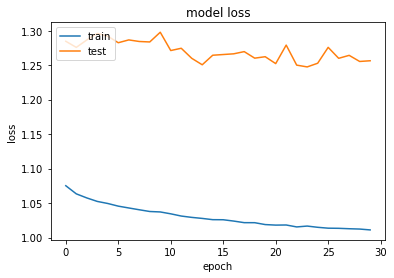

In [54]:
# summarize history for loss
plt.plot(ann_model_history.history['loss'])
plt.plot(ann_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [55]:
print(classification_report(y_test_ann, ann_model_loaded.predict_classes(X_test_ann), target_names=['-1', '0', '1']))

              precision    recall  f1-score   support

          -1       0.35      0.60      0.44       165
           0       0.14      0.01      0.02        89
           1       0.44      0.37      0.40       196

    accuracy                           0.38       450
   macro avg       0.31      0.33      0.29       450
weighted avg       0.35      0.38      0.34       450



## Baseline Classification Model (Random Guesser)

In [56]:
print(classification_report(y_test, [random.choice([-1,0,1]) for i in range(len(y_test))], target_names=['-1', '0', '1']))

              precision    recall  f1-score   support

          -1       0.42      0.38      0.40       165
           0       0.20      0.35      0.25        89
           1       0.43      0.33      0.37       196

    accuracy                           0.35       450
   macro avg       0.35      0.35      0.34       450
weighted avg       0.38      0.35      0.36       450

